# <center> <img src="../../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> Computer Systems Engineering  </center>
---
### <center> Big Data Processing </center>
---
#### <center> **Autumn 2025** </center>

#### <center> **Final Project: Batch Processing** </center>
---

**Date**: October, 2025

**Student Name**:Jaime Antonio Contreras Barragan

**Professor**: Pablo Camarillo Ramirez

# Introduction

Global Mobile Reviews Dataset (2025 Edition). Este dataset cuenta con mucha informacion interesante de reviews de los celulares, resaltando que viene con el pais de origen de la review, en que tienda se compro, si esta verificada, diferentes categorias de calificación (incluyendo una general), entre otros datos que pueden usarse de manera interesante.
Yo quiero aprovechar para lo siguiente:

    Primero que nada enfocarlos datos a solo las compras verificadas, y primero sacar lo obvio, lo mejor de lo mejor:
    -La marca con mejor calificación
    -top de modelos de celular mejor calificación
    -los mejores celulares en cada marca
Pero fuera de estos datos, quiero ver ahora cuales son los mejores sitios de compra, cuales tienen más compras verificadas, rango de edad que compra en cada tienda. Con esto podemos obtener cual es el "mercado" de la plataforma.

# Dataset

In [1]:
!ls -lah /opt/spark/work-dir/jars/postgresql-42.7.8.jar

-rwxrwxrwx 1 root root 1.1M Sep 30 14:01 /opt/spark/work-dir/jars/postgresql-42.7.8.jar


In [2]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Examples on data sources (Files)") \
    .master("spark://spark-master:7077") \
    .config("spark.ui.port", "4040") \
    .config("spark.jars", "/opt/spark/work-dir/jars/postgresql-42.7.8.jar") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("ERROR")

25/10/24 04:16:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
ls -l /opt/spark/work-dir/data/Mobile_Reviews

total 9824
-rwxrwxrwx 1 root root 10056684 Oct 23 03:20 Mobile_Reviews_Sentiment.csv*


In [4]:
from jaimodule.spark_utils import SparkUtils
# Build schema
"""
25 columnas 
"""
schema = SparkUtils.generate_schema([
    ("review_id","int"),
    ("customer_name","string"),
    ("age", "int"),
    ("brand", "string"),
    ("model", "string"),
    ("price_usd", "float"),
    ("price_local", "string"),
    ("currency", "string"),
    ("exchange_rate_to_usd", "float"),
    ("rating", "int"),
    ("review_text", "string"),
    ("sentiment", "string"),
    ("country", "string"),
    ("language", "string"),
    ("review_date", "date"),
    ("verified_purchase", "boolean"),
    ("battery_life_rating", "int"),
    ("camera_rating", "int"),
    ("performance_rating", "int"),
    ("design_rating", "int"),
    ("display_rating", "int"),
    ("review_length", "int"),
    ("word_count", "int"),
    ("helpful_votes", "int"),
    ("source", "string")
])

# Import your module
base_path = "/opt/spark/work-dir/data/Mobile_Reviews/"
mobile_reviews_df = spark.read \
                .option("header", "true") \
                .schema(schema) \
                .csv(base_path) 

# Transformations and Actions

In [5]:
from pyspark.sql.functions import col,desc
"""
Voy a necesitar 1 dataset con con todas las categorias de rating, que esten verificadas, marca y modelo
"""

"""
En la pagina se especifica que este dataset, no solo fue limpiado, si no que revisado manualmente, asi que me voy a dar el lujo de saltarme el dropna,pero de todos modos quitamos repetidos.
"""
mobile_reviews_df = mobile_reviews_df.dropDuplicates()

top_mobile_df= mobile_reviews_df.select(
    col("verified_purchase").alias("verified"),
    col("brand"),
    col("model"),
    col("rating"),
    col("battery_life_rating").alias("battery"),
    col("camera_rating").alias("camera"),
    col("performance_rating").alias("perfomance"),
    col("design_rating").alias("design"),
    col("display_rating").alias("display")
)
#top_mobile_df.show()
store_df= mobile_reviews_df.select(
    col("age"),
    col("verified_purchase").alias("verified"),
    col("country"),
    col("sentiment"),
    col("source")
)
#store_df.show()



In [6]:
from pyspark.sql.functions import avg, count
"""
De los 2 datasets previos, vamos a hacer el resto de transformaciones y aggregaciones.
"""
top_filtered_mobile_df= top_mobile_df.filter("verified = true")

top_mobile_ordered_df= top_filtered_mobile_df.groupBy("model")\
    .agg(avg("rating").alias("avg_rating"))\
    .orderBy(desc("avg_rating"))

top_mobile_ordered_by_brand_df= top_filtered_mobile_df.groupBy("brand")\
    .agg(avg("rating").alias("avg_rating"))\
    .orderBy(desc("avg_rating"))

top_mobile_grouped_by_model_df= top_filtered_mobile_df.groupBy("model")
"""
.limit es una transformacion, pero solo quiero el top 10, lo dejo comentado para pasar la tabla
"""
top_mobile_grouped_by_model_battery= top_mobile_grouped_by_model_df\
    .agg(avg("battery")\
    .alias("avg_battery"))\
    .orderBy(desc("avg_battery"))\
    #.limit(10)

top_mobile_grouped_by_model_camera_df= top_mobile_grouped_by_model_df\
    .agg(avg("camera")\
    .alias("avg_camera"))\
    .orderBy(desc("avg_camera"))\
    #.limit(10)

top_mobile_grouped_by_model_performance_df= top_mobile_grouped_by_model_df\
    .agg(avg("perfomance")\
    .alias("avg_perfomance"))\
    .orderBy(desc("avg_perfomance"))\
    #.limit(10)

top_mobile_grouped_by_model_design_df= top_mobile_grouped_by_model_df\
    .agg(avg("design")\
    .alias("avg_design"))\
    .orderBy(desc("avg_design"))\
    #.limit(10)

top_mobile_grouped_by_model_display_df= top_mobile_grouped_by_model_df\
    .agg(avg("display")\
    .alias("avg_display"))\
    .orderBy(desc("avg_display"))\
    #.limit(10)

#top_mobile_ordered_df.show()
#top_mobile_ordered_by_brand_df.show()
#top_mobile_grouped_by_model_battery_df.show()
#top_mobile_grouped_by_model_camera_df.show()
#top_mobile_grouped_by_model_performance_df.show()
#top_mobile_grouped_by_model_design_df.show()
#top_mobile_grouped_by_model_display_df.show()

In [7]:
from pyspark.sql.functions import when
"""
Ahora el DATASET para sacar los compradores de cada plataforma.
"""
store_grouped_by_source_avg_age_df= store_df.groupBy("source")\
    .agg(avg("age"))\
    .alias("avg_age")

"""
Aqui aproveche las categorias para poder organizar los resultados
"""
store_with_age_category_df = store_df.withColumn(
    "age_category",
    when(col("age") < 26, "adolescent")
    .when(col("age").between(26, 35), "adult")
    .when(col("age").between(36, 45), "senior")
    .when(col("age") > 45, "veteran")
)

store_grouped_by_source_age_category_df = store_with_age_category_df.groupBy("source", "age_category")\
    .agg(count("*").alias("count_age_category"))\
    .orderBy(col("source"),col("age_category"))

#store_grouped_by_source_avg_age_df.show()
#store_grouped_by_source_age_category_df.show()
"""
NOTA: tras revisar los resultados la cantidad de personas por rango de edad es similar, con diferencias maximas de alrededor de 200 unidades
"""

'\nNOTA: tras revisar los resultados la cantidad de personas por rango de edad es similar, con diferencias maximas de alrededor de 200 unidades\n'

# Persistence Data

# JUSTIFICACIÓN
Las tablas principales sin duda deberian entrar a SQL, las tablas pueden dar mucho juego a hacer las consultas diferentes en SQL, y el formato que se maneja es excelente para entender los datos rapidamente.

In [8]:
jdbc_url = "jdbc:postgresql://postgres-iteso:5432/postgres"
table_name_1 = "top_mobile"
table_name_2 = "store"
table_name_3 = "top_mobile_ordered"
table_name_4 = "top_mobile_ordered_by_brand"
table_name_6 = "top_mobile_grouped_by_model_battery"
table_name_7 = "top_mobile_grouped_by_model_camera"
table_name_8 = "top_mobile_grouped_by_model_performance"
table_name_9 = "top_mobile_grouped_by_model_design"
table_name_10 = "top_mobile_grouped_by_model_display"
table_name_11 = "store_grouped_by_source_avg_age"
table_name_12 = "store_grouped_by_source_age_category"

In [9]:
top_mobile_df.write \
    .format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", table_name_1) \
    .option("user", "postgres") \
    .option("password", "Admin@1234") \
    .option("driver", "org.postgresql.Driver") \
    .save()

print("DataFrame successfully written into a PosgreSQL DB !")

[Stage 2:=============================>                             (1 + 1) / 2]

DataFrame successfully written into a PosgreSQL DB !


In [10]:
store_df.write \
    .format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", table_name_2) \
    .option("user", "postgres") \
    .option("password", "Admin@1234") \
    .option("driver", "org.postgresql.Driver") \
    .save()

print("DataFrame successfully written into a PosgreSQL DB !")

[Stage 5:=============================>                             (1 + 1) / 2]

DataFrame successfully written into a PosgreSQL DB !


In [11]:
top_mobile_ordered_df.write \
    .format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", table_name_3) \
    .option("user", "postgres") \
    .option("password", "Admin@1234") \
    .option("driver", "org.postgresql.Driver") \
    .save()

print("DataFrame successfully written into a PosgreSQL DB !")

DataFrame successfully written into a PosgreSQL DB !


In [12]:
top_mobile_ordered_by_brand_df.write \
    .format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", table_name_4) \
    .option("user", "postgres") \
    .option("password", "Admin@1234") \
    .option("driver", "org.postgresql.Driver") \
    .save()

print("DataFrame successfully written into a PosgreSQL DB !")

DataFrame successfully written into a PosgreSQL DB !


In [15]:
top_mobile_grouped_by_model_battery.write \
    .format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", table_name_6) \
    .option("user", "postgres") \
    .option("password", "Admin@1234") \
    .option("driver", "org.postgresql.Driver") \
    .save()

print("DataFrame successfully written into a PosgreSQL DB !")

[Stage 32:=============================>                            (1 + 1) / 2]

DataFrame successfully written into a PosgreSQL DB !


In [16]:
top_mobile_grouped_by_model_camera_df.write \
    .format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", table_name_7) \
    .option("user", "postgres") \
    .option("password", "Admin@1234") \
    .option("driver", "org.postgresql.Driver") \
    .save()

print("DataFrame successfully written into a PosgreSQL DB !")

DataFrame successfully written into a PosgreSQL DB !


In [17]:
top_mobile_grouped_by_model_performance_df.write \
    .format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", table_name_8) \
    .option("user", "postgres") \
    .option("password", "Admin@1234") \
    .option("driver", "org.postgresql.Driver") \
    .save()

print("DataFrame successfully written into a PosgreSQL DB !")

DataFrame successfully written into a PosgreSQL DB !


In [18]:
top_mobile_grouped_by_model_design_df.write \
    .format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", table_name_9) \
    .option("user", "postgres") \
    .option("password", "Admin@1234") \
    .option("driver", "org.postgresql.Driver") \
    .save()

print("DataFrame successfully written into a PosgreSQL DB !")

[Stage 71:=============================>                            (1 + 1) / 2]

DataFrame successfully written into a PosgreSQL DB !


In [19]:
top_mobile_grouped_by_model_display_df.write \
    .format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", table_name_10) \
    .option("user", "postgres") \
    .option("password", "Admin@1234") \
    .option("driver", "org.postgresql.Driver") \
    .save()

print("DataFrame successfully written into a PosgreSQL DB !")

DataFrame successfully written into a PosgreSQL DB !


In [20]:
store_grouped_by_source_avg_age_df.write \
    .format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", table_name_11) \
    .option("user", "postgres") \
    .option("password", "Admin@1234") \
    .option("driver", "org.postgresql.Driver") \
    .save()

print("DataFrame successfully written into a PosgreSQL DB !")

[Stage 97:=============================>                            (1 + 1) / 2]

DataFrame successfully written into a PosgreSQL DB !


In [21]:
store_grouped_by_source_age_category_df.write \
    .format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", table_name_12) \
    .option("user", "postgres") \
    .option("password", "Admin@1234") \
    .option("driver", "org.postgresql.Driver") \
    .save()

print("DataFrame successfully written into a PosgreSQL DB !")

DataFrame successfully written into a PosgreSQL DB !


In [24]:

jdbc_url = "jdbc:postgresql://postgres-iteso:5432/postgres"
db_properties = {
    "user": "postgres",
    "password": "Admin@1234",
    "driver": "org.postgresql.Driver"
}

df = spark.read \
    .jdbc(url=jdbc_url, table=table_name_1, properties=db_properties)

df.printSchema()
#df.show(5, truncate=False)
t2_df = spark.read \
    .jdbc(url=jdbc_url, table=table_name_2, properties=db_properties)

t2_df.printSchema()

t12_df = spark.read \
    .jdbc(url=jdbc_url, table=table_name_12, properties=db_properties)

t12_df.printSchema()

"""
Solo imprimo estas 3 porque seria mucha info desplegar todas, pero para comprobar que si se guardaron.
"""

root
 |-- verified: boolean (nullable = true)
 |-- brand: string (nullable = true)
 |-- model: string (nullable = true)
 |-- rating: integer (nullable = true)
 |-- battery: integer (nullable = true)
 |-- camera: integer (nullable = true)
 |-- perfomance: integer (nullable = true)
 |-- design: integer (nullable = true)
 |-- display: integer (nullable = true)

root
 |-- age: integer (nullable = true)
 |-- verified: boolean (nullable = true)
 |-- country: string (nullable = true)
 |-- sentiment: string (nullable = true)
 |-- source: string (nullable = true)

root
 |-- source: string (nullable = true)
 |-- age_category: string (nullable = true)
 |-- count_age_category: long (nullable = true)



# DAG

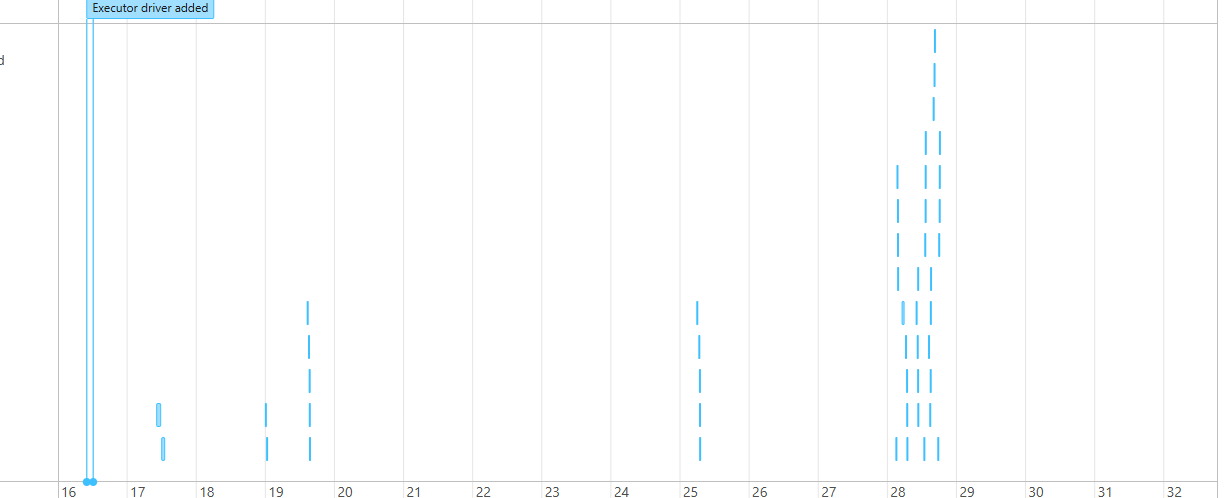

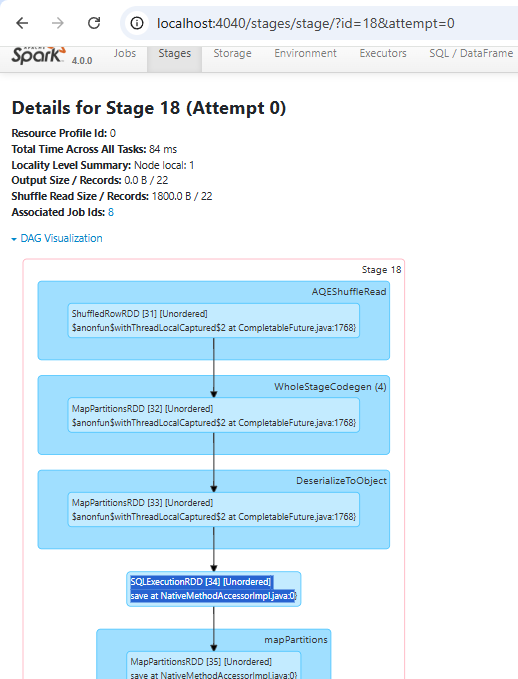

In [25]:
sc.stop()